In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.conv_ae_1D import *
import torch
import random
from torchvision.transforms import transforms as T, Lambda
from pathlib import Path
from config import *
from utils import *
from conv_utils import *

import numpy as np
import platform
import json

architecture='conv_ae1D'

In [4]:
exp_dict = exp_name_folders(path =esa_exploration, architecture=architecture)
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:third_wheel_system_conv_ae1D_sl_16
num selection:1 - exp name:third_wheel_system_conv_ae1D_sl_40


In [18]:
select_exp = '1'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: third_wheel_system_conv_ae1D_sl_40


In [19]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/conv_ae1D/third_wheel_system_conv_ae1D_sl_40/summary.csv


In [20]:
summary.reset_index().head()

,index,Unnamed: 0,name,parameters_number,train_loss,val_loss
0,39,7,"trainCONVAE1D_c5138_00021_21_activation=Elu,ba...",5786,0.001990,0.000121
1,38,38,"trainCONVAE1D_c5138_00009_9_activation=Elu,bat...",4778,0.002053,0.000226
2,37,3,"trainCONVAE1D_c5138_00003_3_activation=Elu,bat...",4778,0.004163,0.001948
3,36,11,"trainCONVAE1D_c5138_00037_37_activation=Elu,ba...",4436,0.005440,0.002868
4,35,9,"trainCONVAE1D_c5138_00020_20_activation=Relu,b...",1442,0.006214,0.003236


In [21]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'activation': 'Elu', 'batch_size': 500, 'dilation': 1, 'epochs': 200, 'filter_num': 28, 'flattened': 0, 'increasing': 0, 'kernel_size': 9, 'latent_dim': 320, 'lr': 0.001, 'lr_patience': 10, 'n_layers': 1, 'pool': 0, 'seq_in_length': 40}


In [31]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

In [32]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path), map_location=device)

params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [33]:
if 'flattened' in params_conf.keys():
    flattened = flattened=params_conf['flattened']
else:
    flattened=False
if 'increasing' in params_conf.keys():
    increasing = flattened=params_conf['increasing']
else:
    increasing=False
    
model = CONV_AE1D(in_channel=params_conf['in_channel'],  length=params_conf['length']
                  , kernel_size=params_conf['kernel_size'], filter_num=params_conf['filter_num'],
                 n_layers=params_conf['n_layers'], activation = params_conf['activation']
                  , stride=params_conf['stride'], pool=params_conf['pool'],
                  flattened=flattened, increasing=increasing).to(device).float()
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal
CONV_AE1D(
  (act): ELU(alpha=1.0)
  (encoder): Encoder(
    (nn_enc): Sequential(
      (enc_lay_0): Sequential(
        (0): Conv1d(4, 28, kernel_size=(9,), stride=(2,), padding=(4,))
        (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (enc_lay_1): Sequential(
        (0): Conv1d(28, 14, kernel_size=(9,), stride=(2,), padding=(4,))
        (1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
    (act): ELU(alpha=1.0)
  )
  (decoder): Decoder(
    (nn_dec): Sequential(
      (dec_lay_0): Sequential(
        (0): ConvTranspose1d(14, 28, kernel_size=(2,), stride=(2,))
        (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (dec_lay_1): Sequential(
       

In [34]:
columns_subset=params_conf['columns_subset']
dataset_subset=params_conf['dataset_subset']
cols = cfg.dataset.columns
scaled = cfg.dataset.scaled
train_val_split = cfg.dataset.train_val_split
target = params_conf['target']
sequence_length = params_conf['sequence_length']
out_window = params_conf['sequence_length']
predict = params_conf['predict']

In [35]:
transform = T.Compose([
    T.ToTensor(),
    Lambda(lambda x: x.permute((0, 2, 1))),
    Lambda(lambda x: x.squeeze())
])
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
df_train, df_test, train_iter, test_iter = \
read_dataset_conv(dataset_name, cfg['dataset']['scaled'],cfg['dataset']['columns_subset']
                  , cfg['dataset']['dataset_subset'], cfg['dataset']['columns'], 
                 cfg['dataset']['train_val_split'], cfg['dataset']['sequence_length']
                  , cfg['dataset']['sequence_length'],  predict=False,
                 batch_size=4, transform=transform )

In [36]:
num_batch=5
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches_conv(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'], arch=architecture)

time horizon 200


In [37]:
yo = model(x.to(device))

In [38]:
seq_len = sequence_length
par_nums = count_parameters(model)

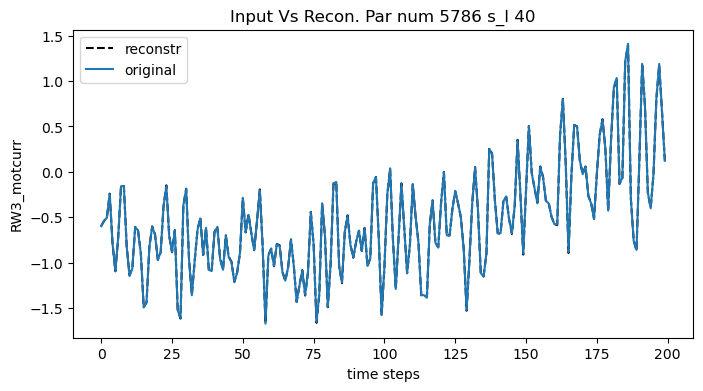

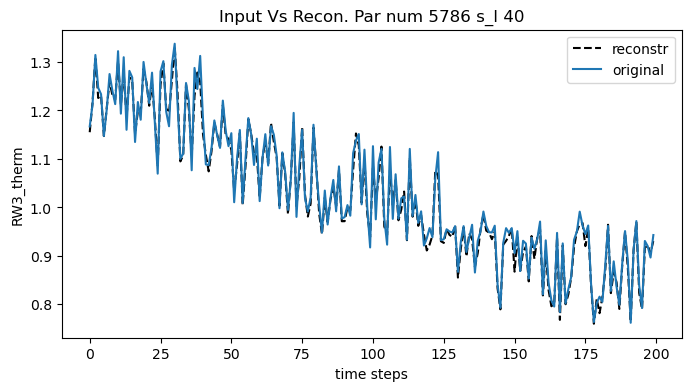

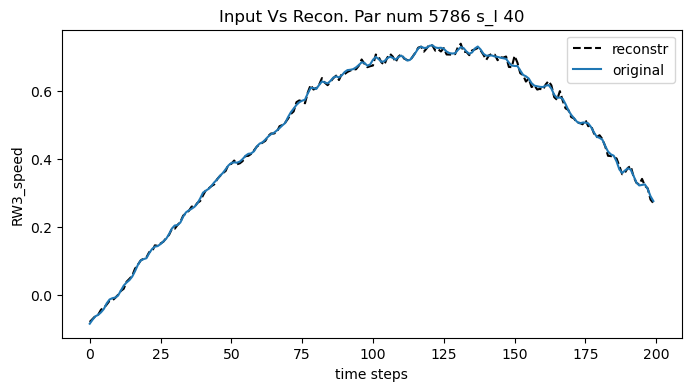

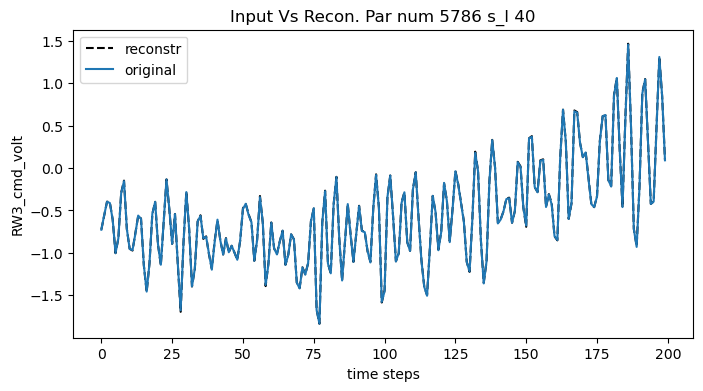

In [39]:
show_results(x, yo,cols,
    model_name, params_conf,
    par_nums, shift,num_batch,
    arch=architecture,
    save=False,)